In [26]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

BASE_DIR = 'Sentiment Analysis/flickr30k_images/flickr30k_images'
WORKING_DIR = 'Sentiment Analysis/working'

# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [51]:
# extract features from image
features = {}

for img_name in tqdm(os.listdir(BASE_DIR)):
    # load the image from file
    img_path = BASE_DIR + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/31784 [00:00<?, ?it/s]

In [52]:
# store features in pickle
pickle.dump(features, open(WORKING_DIR + '/' + 'features_30k.pkl', 'wb'))

In [27]:
with open('Sentiment Analysis/working/features_30k.pkl', 'rb') as f:
    features = pickle.load(f)

In [28]:
with open('Sentiment Analysis/'+'results_30k.txt', 'r') as f:
    next(f)
    captions_doc = f.read()

In [13]:
with open('Sentiment Analysis/working/mapping_30k.pkl', 'rb') as f:
    mapping = pickle.load(f)

In [29]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/31786 [00:00<?, ?it/s]

In [30]:
len(mapping)

31784

In [31]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [32]:
mapping['36979']

['A group of friends playing cards and trying to bluff each other into making a terrible mistake .  ']

In [33]:
# preprocess the text
clean(mapping)
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
len(all_captions)

31785

In [34]:
all_captions[:10]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq someone in blue shirt and hat is standing on stair and leaning against window endseq',
 'startseq two men one in gray shirt one in black shirt standing near stove endseq',
 'startseq two people in the photo are playing the guitar and the other is poking at him endseq',
 'startseq man sits in chair while holding large stuffed animal of lion endseq',
 'startseq girl is on rollerskates talking on her cellphone standing in parking lot endseq',
 'startseq an asian man wearing black suit stands near dark-haired woman and brown-haired woman endseq',
 'startseq two men in germany jumping over rail at the same time without shirts endseq']

In [35]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
pickle.dump(tokenizer, open(WORKING_DIR + '/' + 'tokenizer_30k.pkl', 'wb'))

In [36]:
with open('Sentiment Analysis/working/tokenizer_30k.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

12313

In [37]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

74

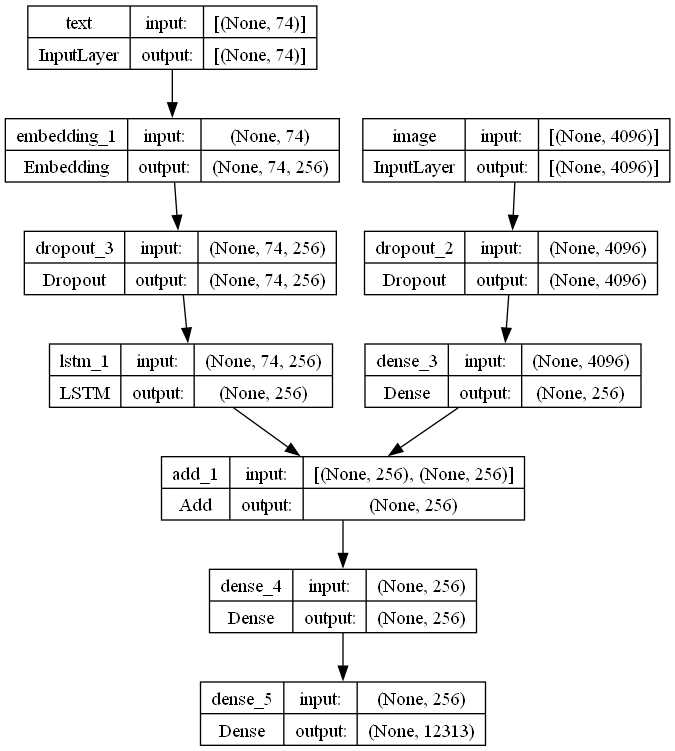

In [38]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [39]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

893/893 [==============================] - 1044s 1s/step - loss: 2.4944


In [40]:
with open('Sentiment Analysis/working/mapping_30k.pkl', 'wb') as pkl_file:
    pickle.dump(mapping, pkl_file)

In [41]:
model.save('Sentiment Analysis/working'+'/best_model_30k.h5')

C:\Users\Sam\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text
# from nltk.translate.bleu_score import corpus_bleu
# # validate with test data
# actual, predicted = list(), list()

# for key in tqdm(test):
#     # get actual caption
#     captions = mapping[key]
#     # predict the caption for image
#     y_pred = predict_caption(model, features[key], tokenizer, max_length)
#     # split into words
#     actual_captions = [caption.split() for caption in captions]
#     y_pred = y_pred.split()
#     # append to the list
#     actual.append(actual_captions)
#     predicted.append(y_pred)
#     # calcuate BLEU score
#     print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
#     print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

In [43]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join("Sentiment Analysis/flickr8k", image_name)
    image = Image.open(img_path)
#     captions = mapping[image_id]
#     print('---------------------Actual---------------------')
#     for caption in captions:
#         print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [44]:
generate_caption("1001773457_577c3a7d70.jpg")

KeyError: '1001773457_577c3a7d70'

In [24]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [46]:
image_path = 'Sentiment Analysis/puppy.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq two dogs one black and one white play with tennis ball in the grass endseq'

In [50]:
from textblob import TextBlob

# Example sentence
sentence = "young boy wearing blue shirt and blue shorts is holding trophy and is wading in the water"

# Create a TextBlob object
blob = TextBlob(sentence)

# Analyze sentiment
sentiment_score = blob.sentiment.polarity

# Print sentiment score
print("Sentiment Score:", sentiment_score)

# Print sentiment label
if sentiment_score > 0:
    print("Sentiment: Positive")
elif sentiment_score < 0:
    print("Sentiment: Negative")
else:
    print("Sentiment: Neutral")


Sentiment Score: 0.03333333333333333
Sentiment: Positive


In [52]:
from textblob import TextBlob

# Example sentence
sentence = "man in blue shirt and sunglasses is sitting on the edge of the road with his eyes closed"

# Create a TextBlob object
blob = TextBlob(sentence)

# Analyze sentiment
sentiment_score = blob.sentiment.polarity

# Print sentiment score
print("Sentiment Score:", sentiment_score)

# Print sentiment label
if sentiment_score > 0:
    print("Sentiment: Positive")
elif sentiment_score < 0:
    print("Sentiment: Negative")
else:
    print("Sentiment: Neutral")


Sentiment Score: -0.05
Sentiment: Negative
